In [20]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [22]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [23]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

This is showing 68 because we divided the images into batches of 68(68*32=2176, since last batch doesn't contain 32) 

In [24]:
len(dataset)

68

In [25]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1]


In [26]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[163. 161. 172.]
  [129. 127. 138.]
  [108. 106. 117.]
  ...
  [163. 161. 175.]
  [158. 156. 170.]
  [153. 151. 165.]]

 [[149. 147. 158.]
  [ 98.  96. 107.]
  [144. 142. 153.]
  ...
  [159. 157. 171.]
  [165. 163. 177.]
  [168. 166. 180.]]

 [[100.  98. 109.]
  [117. 115. 126.]
  [188. 186. 199.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[142. 138. 153.]
  [120. 116. 131.]
  [136. 132. 147.]
  ...
  [180. 178. 191.]
  [178. 176. 189.]
  [189. 187. 200.]]

 [[118. 114. 129.]
  [102.  98. 113.]
  [157. 153. 168.]
  ...
  [177. 175. 188.]
  [172. 170. 183.]
  [177. 175. 188.]]

 [[123. 119. 134.]
  [128. 124. 139.]
  [148. 144. 159.]
  ...
  [205. 203. 216.]
  [188. 186. 199.]
  [173. 171. 184.]]]


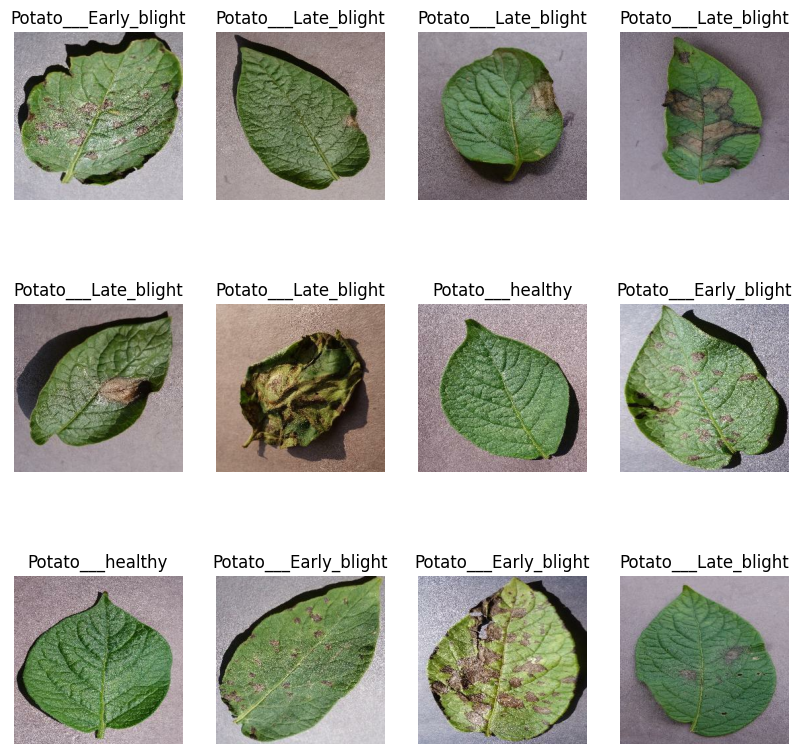

In [27]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))  #astype("uinit8") is used for converting the floating point values to integers
        plt.title(class_names[label_batch[i]])
        plt.axis("off") # for removing the numbering at x and y axises
    


In [28]:
train_size=0.8
len(dataset)*0.8


54.400000000000006

In [29]:
train_ds=dataset.take(54)

In [30]:
val_and_test_ds=dataset.skip(54) 
len(val_and_test_ds)

14

In [31]:
validation_size=0.1
len(dataset)*validation_size

6.800000000000001

In [32]:
val_ds=val_and_test_ds.take(6)

In [33]:
test_ds=val_and_test_ds.skip(6)
len(test_ds)

8

In [34]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(dataset)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [35]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset) # same as the train_test_split in ML

In [36]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


In [37]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Now we are Resizing the image to 256x256 so that even if we give an input image which is not in 256x256 dimension it will be converted into that dimension.
Then we are rescaling the values of image by dividing it with 255 since the R G B contains the values from 0 to 255.

In [40]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])


Now we are training our model with the image Roated, Flipped or changing contrast so that when we give input images like that out model can correctly predict it

In [41]:
data_augmetation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [49]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmetation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

c:\Users\varun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 630ms/step - accuracy: 0.4480 - loss: 0.9706 - val_accuracy: 0.4948 - val_loss: 0.8200
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.5301 - loss: 0.8706 - val_accuracy: 0.8073 - val_loss: 0.5666
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 574ms/step - accuracy: 0.8272 - loss: 0.4758 - val_accuracy: 0.7604 - val_loss: 0.6477
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 545ms/step - accuracy: 0.8238 - loss: 0.4281 - val_accuracy: 0.8125 - val_loss: 0.4177
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.8601 - loss: 0.3391 - val_accuracy: 0.9219 - val_loss: 0.2016
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 446ms/step - accuracy: 0.9372 - loss: 0.1654 - val_accuracy: 0.9583 - val_loss: 0.1239
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 459ms/step - accuracy: 0.9524 - loss: 0.1492 - val_accuracy: 0.9115 - val_loss: 0.2183
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 450ms/step - accuracy: 0.9504 - loss: 0.1323 - val_accu

In [53]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9936 - loss: 0.0153


In [54]:
scores

[0.014286315068602562, 0.99609375]

In [55]:
history

In [56]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [57]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [59]:
history.history['accuracy']

[0.4982638955116272,
 0.6226851940155029,
 0.8298611044883728,
 0.8518518805503845,
 0.890625,
 0.9351851940155029,
 0.9508101940155029,
 0.9537037014961243,
 0.9600694179534912,
 0.9317129850387573,
 0.9403935074806213,
 0.9496527910232544,
 0.9438657164573669,
 0.9618055820465088,
 0.9629629850387573,
 0.96875,
 0.96875,
 0.9658564925193787,
 0.9496527910232544,
 0.9658564925193787,
 0.9722222089767456,
 0.9774305820465088,
 0.9780092835426331,
 0.9814814925193787,
 0.9745370149612427,
 0.9866898059844971,
 0.9855324029922485,
 0.9756944179534912,
 0.9861111044883728,
 0.9855324029922485,
 0.9710648059844971,
 0.984375,
 0.9589120149612427,
 0.9809027910232544,
 0.9814814925193787,
 0.9901620149612427,
 0.9872685074806213,
 0.9947916865348816,
 0.9907407164573669,
 0.9832175970077515,
 0.9791666865348816,
 0.9861111044883728,
 0.9918981194496155,
 0.9861111044883728,
 0.9918981194496155,
 0.9942129850387573,
 0.9884259104728699,
 0.9936342835426331,
 0.9907407164573669,
 0.9930555820

In [60]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

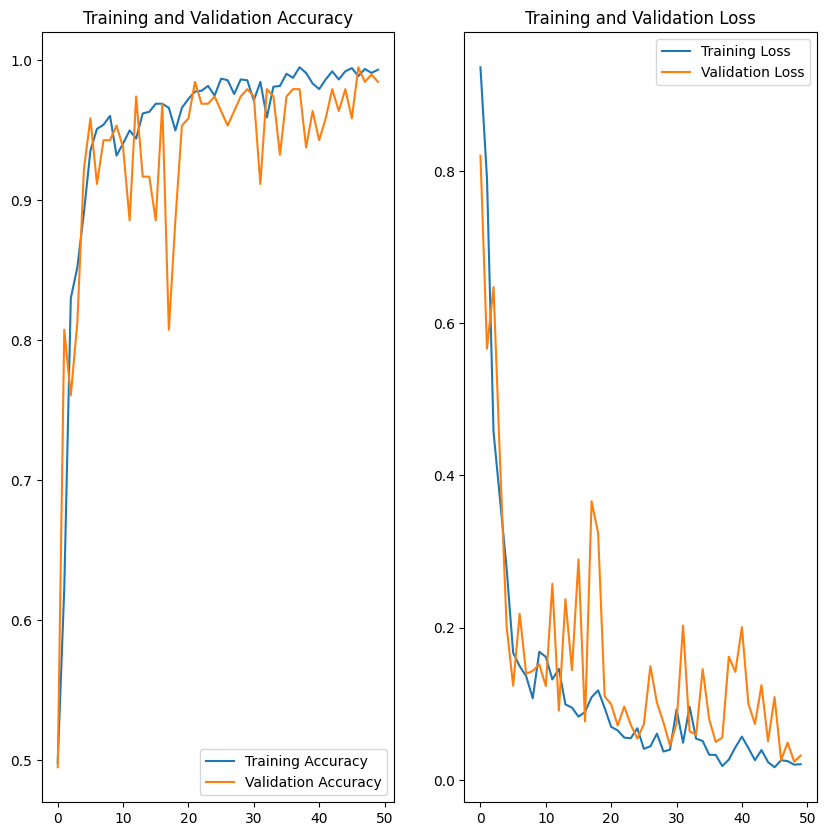

In [63]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First image to predict
Actual Label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Predicted Label: Potato___Late_blight


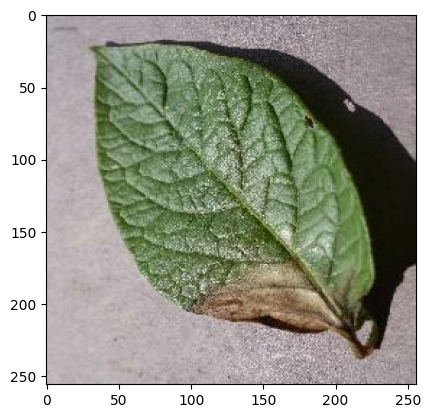

In [70]:
import numpy as np

for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[first_label])
    
    batct_prediction=model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batct_prediction[0])])

In [85]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


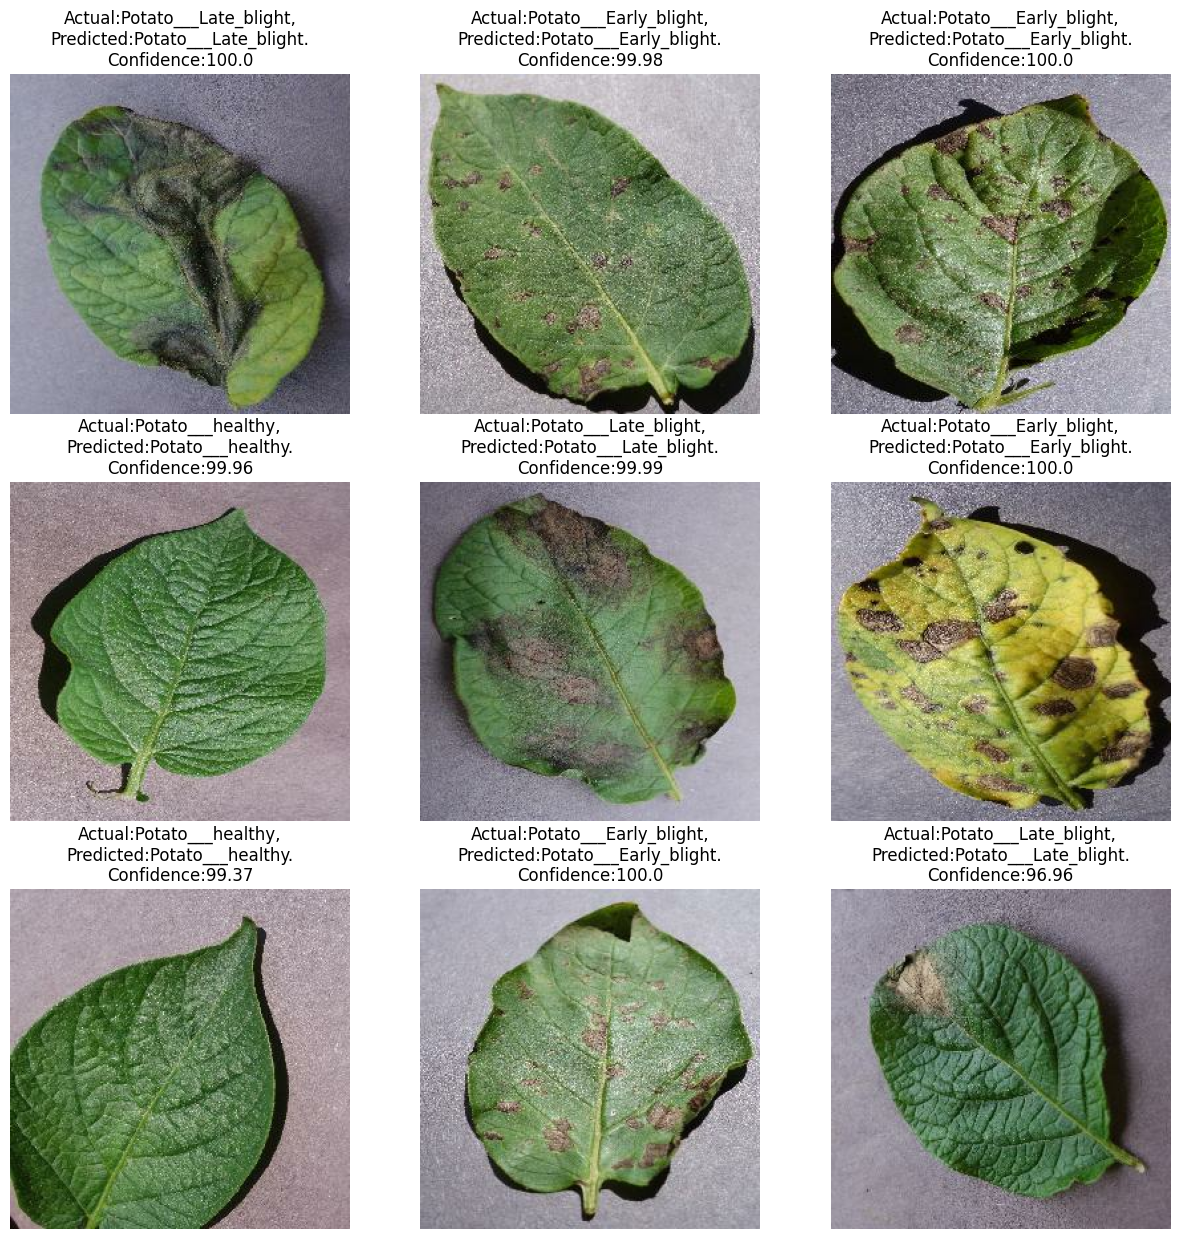

In [88]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\nPredicted:{predicted_class}.\nConfidence:{confidence}")
        plt.axis("off")